In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../..')
#import lib.variational_method as variational
import lib.variational_method.eigenvalues as eigenvalues
from lib.data import super_gauss
from lib.mesurements import mse
import numpy as np
%matplotlib inline

В левой части для вариационного метода

$$B_2 \Lambda_1 u + B_1 \Lambda_2 u + \alpha B_1 B_2 u + \gamma \Lambda_1 \Lambda_2 u = B_1 G_1 g_1 + G_2 B_2 g_2$$

Матрицы $B, \Lambda, G$ получаются из различных вариантов скалярных произведений $\phi_i(x), \phi'_i(x)$, деленных на $h$

Непонятна причина по которой выполняется это деление. Напишу реализацию для метода без этого деления.

$(\phi'_i(x), \phi'_k(x)), (\phi_i(x), \phi_k(x))$

In [2]:
def create_l(dim, h):
    """
    Матрица L, 2-я производная
    :param dim: размерность
    :param h: шаг сетки
    :return:[[ 2, -1 0],
             [-1, 2, -1],
             [0,-1, 2]] / h
    """
    diag1 = np.array([2 if i == j else 0 for i in range (dim) for j in range(dim)]).reshape(dim,dim)
    diag2 = np.array([-1 if np.abs(i - j) == 1 else 0 for i in range (dim) for j in range(dim)]).reshape(dim,dim)
    return (diag1 + diag2) / h

In [3]:
def create_b(dim):
    """
    Матрица B
    :param dim: размерность
    :param h: шаг сетки
    :return: I - 1/6 * h^2 * L
            [[ 2/3, 1/6, 0],
             [ 1/6, 2/3, 1/6],
             [ 0, 1/6, 2/3]]
    """
    return np.eye(dim) - 1 / 6 * create_l(dim, 1) * 1

In [4]:
def create_g1(dim):
    """
    Матрица G1
    :param dim: размерность
    :param h: шаг сетки
    :return: [[0, -0.5, 0],
             [[0.5, 0, -0.5],
             [[0, 0.5, 0]]
    """
    diag1 = np.array([-1 if i - j == -1 else 0 for i in range (dim) for j in range(dim)]).reshape(dim,dim)
    diag2 = np.array([1 if i - j == 1 else 0 for i in range (dim) for j in range(dim)]).reshape(dim,dim)
    return 0.5 * (diag1 + diag2)

In [5]:
def create_g2(dim):
    """
    Матрица G2
    :param dim: размерность
    :param h: шаг сетки
    :return: [[ 0. ,  0.5,  0. ],
             [-0.5,  0. ,  0.5],
             [ 0. , -0.5,  0. ]]
    """
    return create_g1(dim).T

In [6]:
def _f1(g1, h1):
    """
    F1 составлющая матрицы F
    :param g1: 2d array. Градиент по x
    :param h1: шаг сетки по x
    :return: 2d array
    """
    dim = g1.shape
    tmp = np.dot(create_g1(dim[0]), g1)
    return np.dot(tmp, create_b(dim[1]))


def _f2(g2, h2):
    """
    F2 составляющая матрицы F
    :param g2: 2d array. Градиент по y
    :param h2: шаг сетки по y
    :return: 2d array
    """
    dim = g2.shape
    tmp = np.dot(create_b(dim[0]), g2)
    return np.dot(tmp, create_g2(dim[1]))


def _get_f_matrix(g1, g2, h1, h2):
    """
    Матрица F. Правая часть в разностной схеме метода.
    :param g1: 2d array. Градиент по x
    :param g2: 2d array. Градиент по y
    :param h1: Шаг сетки по x
    :param h2: Шаг сетки по y
    :return: 2d array
    """
    return _f1(g1, h1) + _f2(g2, h2)


def method(g1, g2, h1, h2, alpha, gamma):
    """
    Метод. Принимает градиенты по x, y. Параметры регуляризации alga, gamma.
    Возвращает восстановленный волновой фронт.
    :param g1: 2d array. Градиент по x
    :param g2: 2d array. Градиент по y
    :param h1: Шаг сетки по x
    :param h2: Шаг сетки по y
    :param alpha: параметр регуляризации
    :param gamma: параметр регуляризации
    :return:
    """
    f = np.fft.fft2(_get_f_matrix(g1, g2, h1, h2))
    lambda1 = eigenvalues.get_lambda(f.shape[0], h1)
    lambda2 = eigenvalues.get_lambda(f.shape[1], h2)

    mu1 = eigenvalues.get_mu(f.shape[0], h1)
    mu2 = eigenvalues.get_mu(f.shape[1], h2)

    res = np.zeros(f.shape, dtype=complex)
    for k in range(res.shape[0]):
        for l in range(res.shape[1]):
            res[k][l] = (lambda1[k] * mu2[l] + mu1[k] * lambda2[l] +
                         alpha * mu1[k] * mu2[l] + gamma * lambda1[k] * lambda2[l])
    
    res = np.fft.ifft2(f / res)
    return np.real(res)

def normilize(front):
    front -= front.min()
    front /= front.max()
    return front

0.0006689397037771127


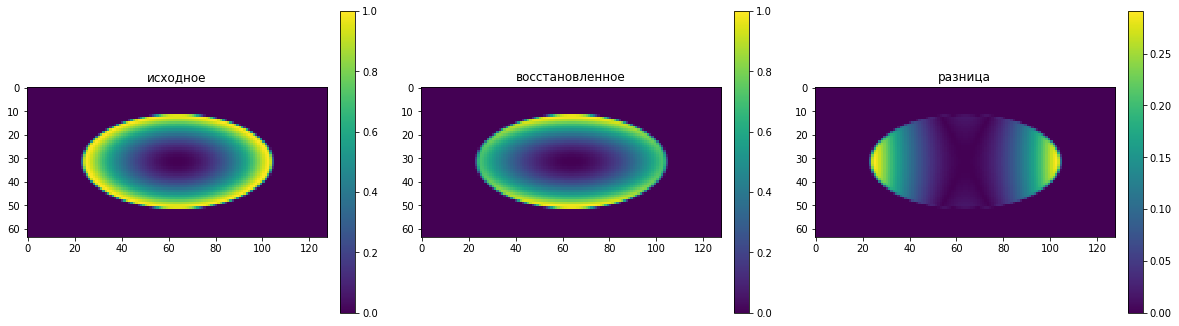

In [12]:
M = 64
N = 128
h1 = 2 * np.pi / M
h2 = 2 * np.pi / N
x, y = np.mgrid[-np.pi:np.pi:1j * M, -np.pi:np.pi:1j * N]
#h1 = x[1,0] - x[0,0]
#h2 = y[0,1] - y[0,0]
gauss = super_gauss(x, y, 2, 40)
front = x**2 + y**2
g1 = 2 * x
g2 = 2 * y
g1 *= gauss
g2 *= gauss
front = normilize(front)
front *= gauss
front = normilize(front)

restored_front = method(g1, g2, h1, h2, 0.0002, 0.001)

restored_front = normilize(restored_front)
restored_front *= gauss
restored_front = normilize(restored_front)

print(mse(front, restored_front))
fig, axes = plt.subplots(1, 3, figsize = (20, 40))
img1 = axes[0].imshow(front)
img2 = axes[1].imshow(restored_front)
img3 = axes[2].imshow(np.abs(restored_front -front))
axes[0].set_title('исходное')
axes[1].set_title('восстановленное')
axes[2].set_title('разница')
fig.colorbar(img1, ax = axes[0],fraction=0.046, pad=0.04)
fig.colorbar(img2, ax = axes[1],fraction=0.046, pad=0.04)
fig.colorbar(img3, ax = axes[2],fraction=0.046, pad=0.04)

5.0284869260094543e-05


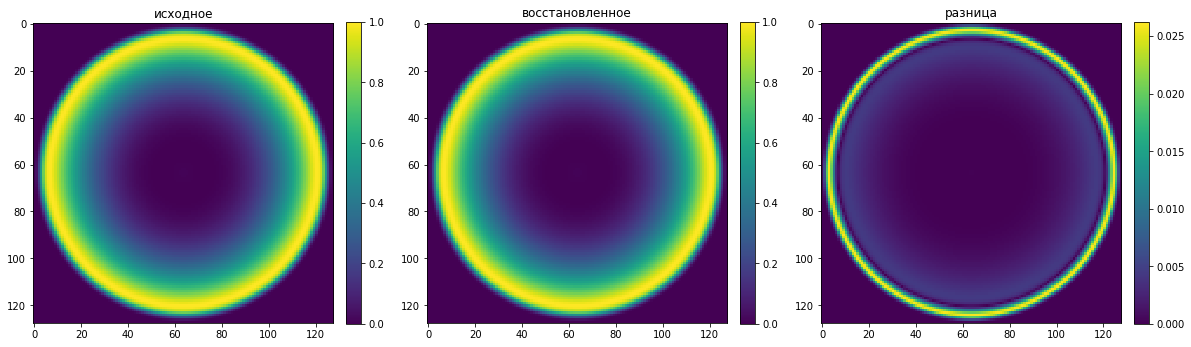

In [13]:
M = 7
h1 = 2 * np.pi / 2 ** M
h2 = 2 * np.pi / 2 ** M
x, y = np.mgrid[-np.pi:np.pi:1j * 2**M * 1j, -np.pi:np.pi:1j * 1j * 2 **M]
gauss = super_gauss(x, y, 3, 20)
front = 3*(x**2 + y**2)*np.sqrt(x**2 + y**2) - 2*np.sqrt(x**2 + y**2)
g1 = (9*x**3 + 6*x*y**2 + 3*x*y**2 - 2*x)/np.sqrt(x**2 + y**2)
g2 = (9*y**3 + 6*y*x**2 + 3*x**2*y - 2*y)/np.sqrt(x**2 + y**2)
g1 *= gauss
g2 *= gauss
front = normilize(front)
front *= gauss
front = normilize(front)
restored_front = method(g1, g2, h1, h2, 0.002, 0.001)

restored_front = normilize(restored_front)
restored_front *= gauss
restored_front = normilize(restored_front)

print(mse(front, restored_front))
fig, axes = plt.subplots(1, 3, figsize = (20, 40))
img1 = axes[0].imshow(front)
img2 = axes[1].imshow(restored_front)
img3 = axes[2].imshow(np.abs(restored_front -front))
axes[0].set_title('исходное')
axes[1].set_title('восстановленное')
axes[2].set_title('разница')
fig.colorbar(img1, ax = axes[0],fraction=0.046, pad=0.04)
fig.colorbar(img2, ax = axes[1],fraction=0.046, pad=0.04)
fig.colorbar(img3, ax = axes[2],fraction=0.046, pad=0.04)


# Итоги:
1. В исходной программе найдет баг для G1, $h \ast \ast 2$ , должно быть $2 \ast h$
2. Похоже, что этот h никакой роли не играет
3. Как точность зависит от соотношения сторон?
4. Нужно еще разобраться с тем как строить сетку. При последнем полиноме функции g1 получается с nan-ом , и все валится когда квадратная матрица
5. g1, g2 в некоторых случаях нужно обрезать гауссом($x^2 + y^2$), а в некоторых нет

# Сравним теперь с делением и без

In [20]:
import sys
sys.path.append("../..")
import lib
import numpy as np
from lib.variational_method.variational import method as variational_method


without divide mse: 0.0003255498861793369
with    divide mse: 1.0588854808827193e-05


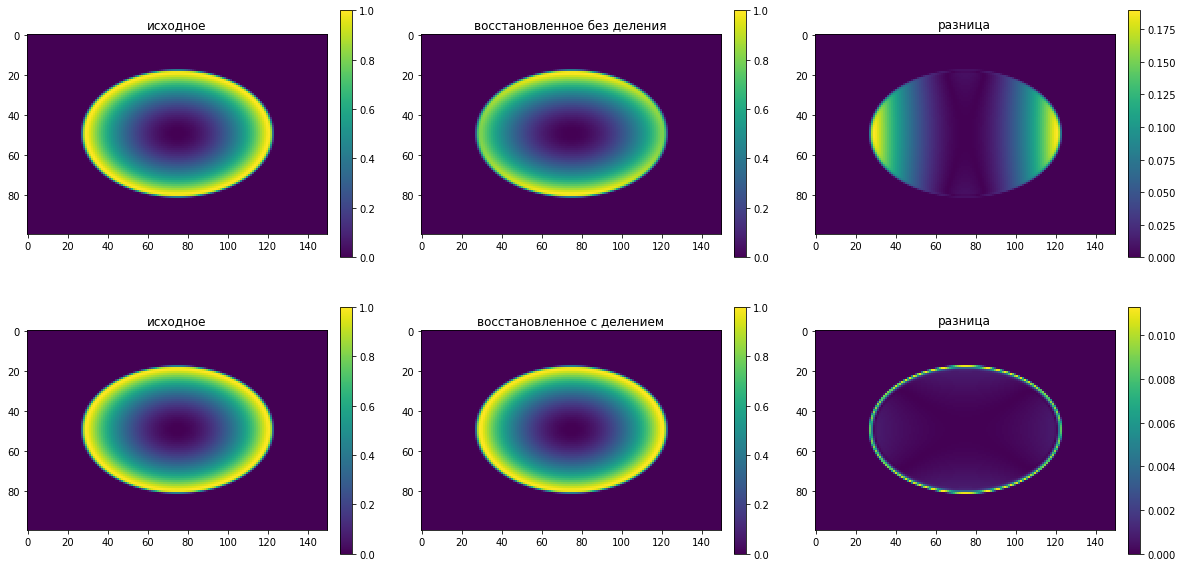

In [41]:
M = 7
h1 = 2 * np.pi / 100
h2 = 2 * np.pi / 150
x, y = np.mgrid[-np.pi:np.pi:1j * 100, -np.pi:np.pi:1j * 150]

gauss = super_gauss(x, y, 2, 40)
front = x**2 + y**2
g1 = 2 * x
g2 = 2 * y

g1 *= gauss
g2 *= gauss
front = normilize(front)
front *= gauss
front = normilize(front)

restored_front = method(g1, g2, h1, h2, 0.0002, 0.001)

restored_front = normilize(restored_front)
restored_front *= gauss
restored_front = normilize(restored_front)

restored_front_with_divide = variational_method(g1, g2, h1, h2, 0.0002, 0.001)

restored_front_with_divide = normilize(restored_front_with_divide)
restored_front_with_divide *= gauss
restored_front_with_divide = normilize(restored_front_with_divide)

print("without divide mse:", mse(front, restored_front))
print("with    divide mse:", mse(front, restored_front_with_divide))

fig, axes = plt.subplots(2, 3, figsize = (20, 10))
img1 = axes[0,0].imshow(front)
img2 = axes[0,1].imshow(restored_front)
img3 = axes[0,2].imshow(np.abs(restored_front -front))
axes[0,0].set_title('исходное')
axes[0,1].set_title('восстановленное без деления')
axes[0,2].set_title('разница')
fig.colorbar(img1, ax = axes[0,0],fraction=0.046, pad=0.04)
fig.colorbar(img2, ax = axes[0,1],fraction=0.046, pad=0.04)
fig.colorbar(img3, ax = axes[0,2],fraction=0.046, pad=0.04)

img1 = axes[1,0].imshow(front)
img2 = axes[1,1].imshow(restored_front_with_divide)
img3 = axes[1,2].imshow(np.abs(restored_front_with_divide - front))
axes[1,0].set_title('исходное')
axes[1,1].set_title('восстановленное c делением')
axes[1,2].set_title('разница')
fig.colorbar(img1, ax = axes[1,0],fraction=0.046, pad=0.04)
fig.colorbar(img2, ax = axes[1,1],fraction=0.046, pad=0.04)
fig.colorbar(img3, ax = axes[1,2],fraction=0.046, pad=0.04)

на $x^2 + y^2$ выходит лучше с делением

посмотрим на другом.

3-го порядка , квадратная матрица.

without divide mse: 9.29356704887078e-06
with    divide mse: 9.293567048870728e-06


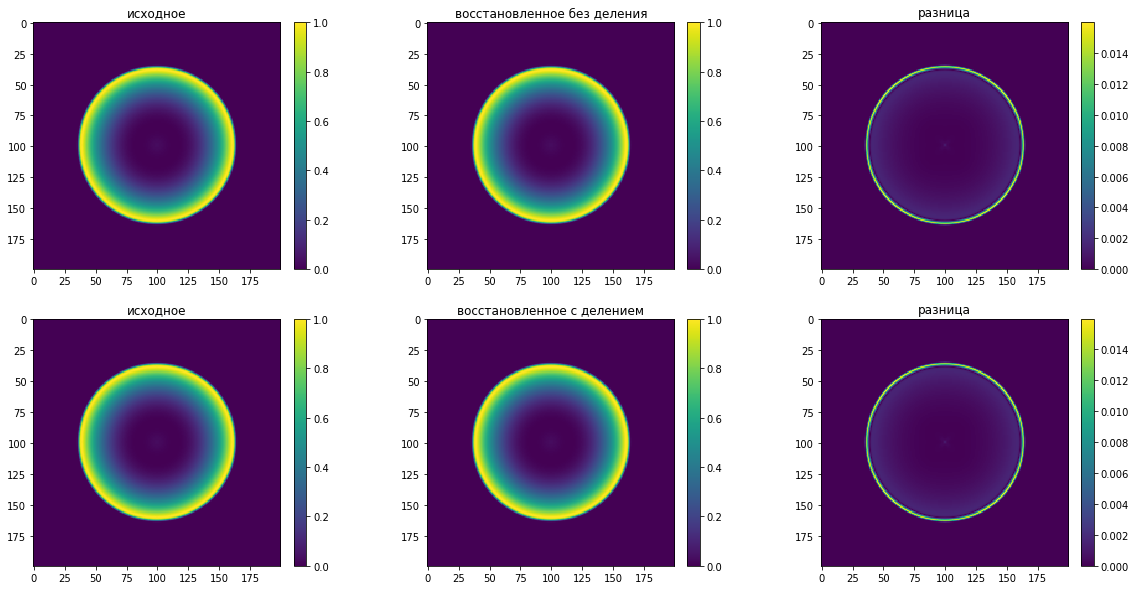

In [43]:
M = 7
h1 = 2 * np.pi / 200
h2 = 2 * np.pi / 200
x, y = np.mgrid[-np.pi:np.pi:1j * 200, -np.pi:np.pi:1j * 200]

gauss = super_gauss(x, y, 2, 40)
front = 3*(x**2 + y**2)*np.sqrt(x**2 + y**2) - 2*np.sqrt(x**2 + y**2)
g1 = (9*x**3 + 6*x*y**2 + 3*x*y**2 - 2*x)/np.sqrt(x**2 + y**2)
g2 = (9*y**3 + 6*y*x**2 + 3*x**2*y - 2*y)/np.sqrt(x**2 + y**2)

g1 *= gauss
g2 *= gauss
front = normilize(front)
front *= gauss
front = normilize(front)

restored_front = method(g1, g2, h1, h2, 0.0002, 0.001)

restored_front = normilize(restored_front)
restored_front *= gauss
restored_front = normilize(restored_front)

restored_front_with_divide = variational_method(g1, g2, h1, h2, 0.0002, 0.001)

restored_front_with_divide = normilize(restored_front_with_divide)
restored_front_with_divide *= gauss
restored_front_with_divide = normilize(restored_front_with_divide)

print("without divide mse:", mse(front, restored_front))
print("with    divide mse:", mse(front, restored_front_with_divide))

fig, axes = plt.subplots(2, 3, figsize = (20, 10))
img1 = axes[0,0].imshow(front)
img2 = axes[0,1].imshow(restored_front)
img3 = axes[0,2].imshow(np.abs(restored_front -front))
axes[0,0].set_title('исходное')
axes[0,1].set_title('восстановленное без деления')
axes[0,2].set_title('разница')
fig.colorbar(img1, ax = axes[0,0],fraction=0.046, pad=0.04)
fig.colorbar(img2, ax = axes[0,1],fraction=0.046, pad=0.04)
fig.colorbar(img3, ax = axes[0,2],fraction=0.046, pad=0.04)

img1 = axes[1,0].imshow(front)
img2 = axes[1,1].imshow(restored_front_with_divide)
img3 = axes[1,2].imshow(np.abs(restored_front_with_divide - front))
axes[1,0].set_title('исходное')
axes[1,1].set_title('восстановленное c делением')
axes[1,2].set_title('разница')
fig.colorbar(img1, ax = axes[1,0],fraction=0.046, pad=0.04)
fig.colorbar(img2, ax = axes[1,1],fraction=0.046, pad=0.04)
fig.colorbar(img3, ax = axes[1,2],fraction=0.046, pad=0.04)

3-го порядка, прямоугольная матрица.

without divide mse: 0.0004730239920115542
with    divide mse: 1.5121027734790948e-05


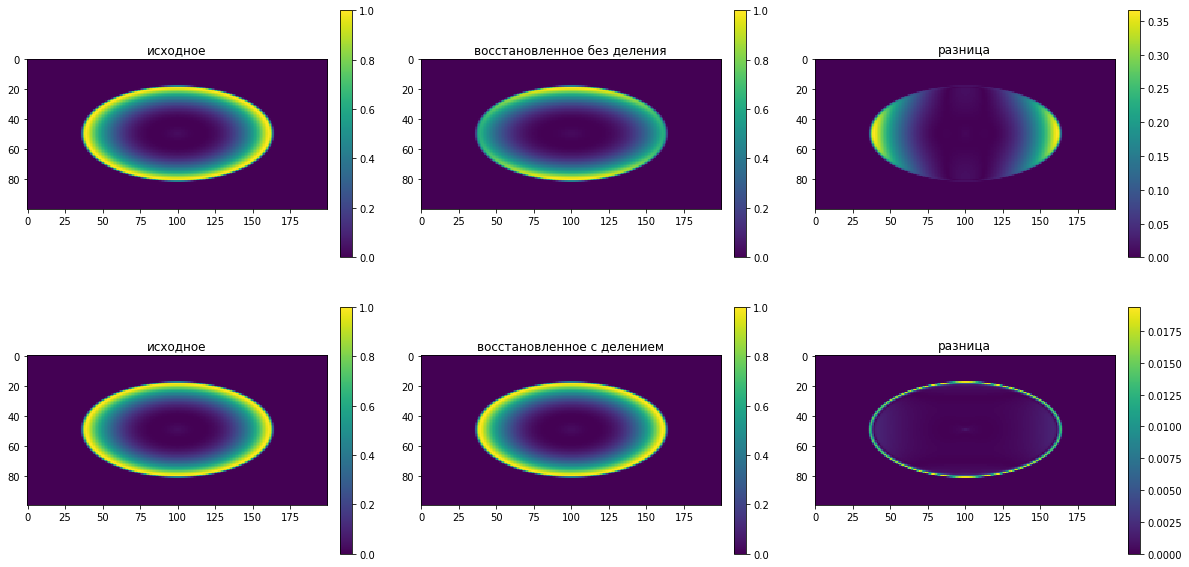

In [44]:
M = 7
h1 = 2 * np.pi / 100
h2 = 2 * np.pi / 200
x, y = np.mgrid[-np.pi:np.pi:1j * 100, -np.pi:np.pi:1j * 200]

gauss = super_gauss(x, y, 2, 40)
front = 3*(x**2 + y**2)*np.sqrt(x**2 + y**2) - 2*np.sqrt(x**2 + y**2)
g1 = (9*x**3 + 6*x*y**2 + 3*x*y**2 - 2*x)/np.sqrt(x**2 + y**2)
g2 = (9*y**3 + 6*y*x**2 + 3*x**2*y - 2*y)/np.sqrt(x**2 + y**2)

g1 *= gauss
g2 *= gauss
front = normilize(front)
front *= gauss
front = normilize(front)

restored_front = method(g1, g2, h1, h2, 0.0002, 0.001)

restored_front = normilize(restored_front)
restored_front *= gauss
restored_front = normilize(restored_front)

restored_front_with_divide = variational_method(g1, g2, h1, h2, 0.0002, 0.001)

restored_front_with_divide = normilize(restored_front_with_divide)
restored_front_with_divide *= gauss
restored_front_with_divide = normilize(restored_front_with_divide)

print("without divide mse:", mse(front, restored_front))
print("with    divide mse:", mse(front, restored_front_with_divide))

fig, axes = plt.subplots(2, 3, figsize = (20, 10))
img1 = axes[0,0].imshow(front)
img2 = axes[0,1].imshow(restored_front)
img3 = axes[0,2].imshow(np.abs(restored_front -front))
axes[0,0].set_title('исходное')
axes[0,1].set_title('восстановленное без деления')
axes[0,2].set_title('разница')
fig.colorbar(img1, ax = axes[0,0],fraction=0.046, pad=0.04)
fig.colorbar(img2, ax = axes[0,1],fraction=0.046, pad=0.04)
fig.colorbar(img3, ax = axes[0,2],fraction=0.046, pad=0.04)

img1 = axes[1,0].imshow(front)
img2 = axes[1,1].imshow(restored_front_with_divide)
img3 = axes[1,2].imshow(np.abs(restored_front_with_divide - front))
axes[1,0].set_title('исходное')
axes[1,1].set_title('восстановленное c делением')
axes[1,2].set_title('разница')
fig.colorbar(img1, ax = axes[1,0],fraction=0.046, pad=0.04)
fig.colorbar(img2, ax = axes[1,1],fraction=0.046, pad=0.04)
fig.colorbar(img3, ax = axes[1,2],fraction=0.046, pad=0.04)

# Итог. 
На квадратных примерно одно и тоже. На прямоугольных лучше с делением.

Деление на $h$ нужно, чтобы получался оператор второй разностной производной из $\Lambda$.